In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
dataset_dir = "Arabic Braille"

image_size = (50, 50)
batch_size = 32  #Default batch size
validation_split = 0.2

# Load the dataset (without splitting)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=image_size,
    batch_size=batch_size,  # Specify the batch size
    label_mode='int',
    shuffle=False  # Disable shuffling
)

# Load the training dataset (80% of data)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,  # Use 20% for validation
    subset="training",  # Specify the subset for training
    seed=1234,  # Ensure shuffling is consistent (No overlap)
    image_size=image_size,
    batch_size=batch_size  # Specify the batch size
)

# Load the validation dataset (20% of data)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,  # Use 20% for validation
    subset="validation",  # Specify the subset for validation
    seed=1234,  # Ensure shuffling is consistent (No overlap)
    image_size=image_size,
    batch_size=batch_size  # Specify the batch size
)


Found 3267 files belonging to 33 classes.
Found 3267 files belonging to 33 classes.
Using 2614 files for training.
Found 3267 files belonging to 33 classes.
Using 653 files for validation.


In [3]:
# Get one batch of data from train_dataset
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Images shape: (32, 50, 50, 3)
Labels shape: (32,)


In [4]:
class_names = train_dataset.class_names
print(class_names) 
print(len(class_names))

['آ', 'أ', 'ؤ', 'ئ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي']
33


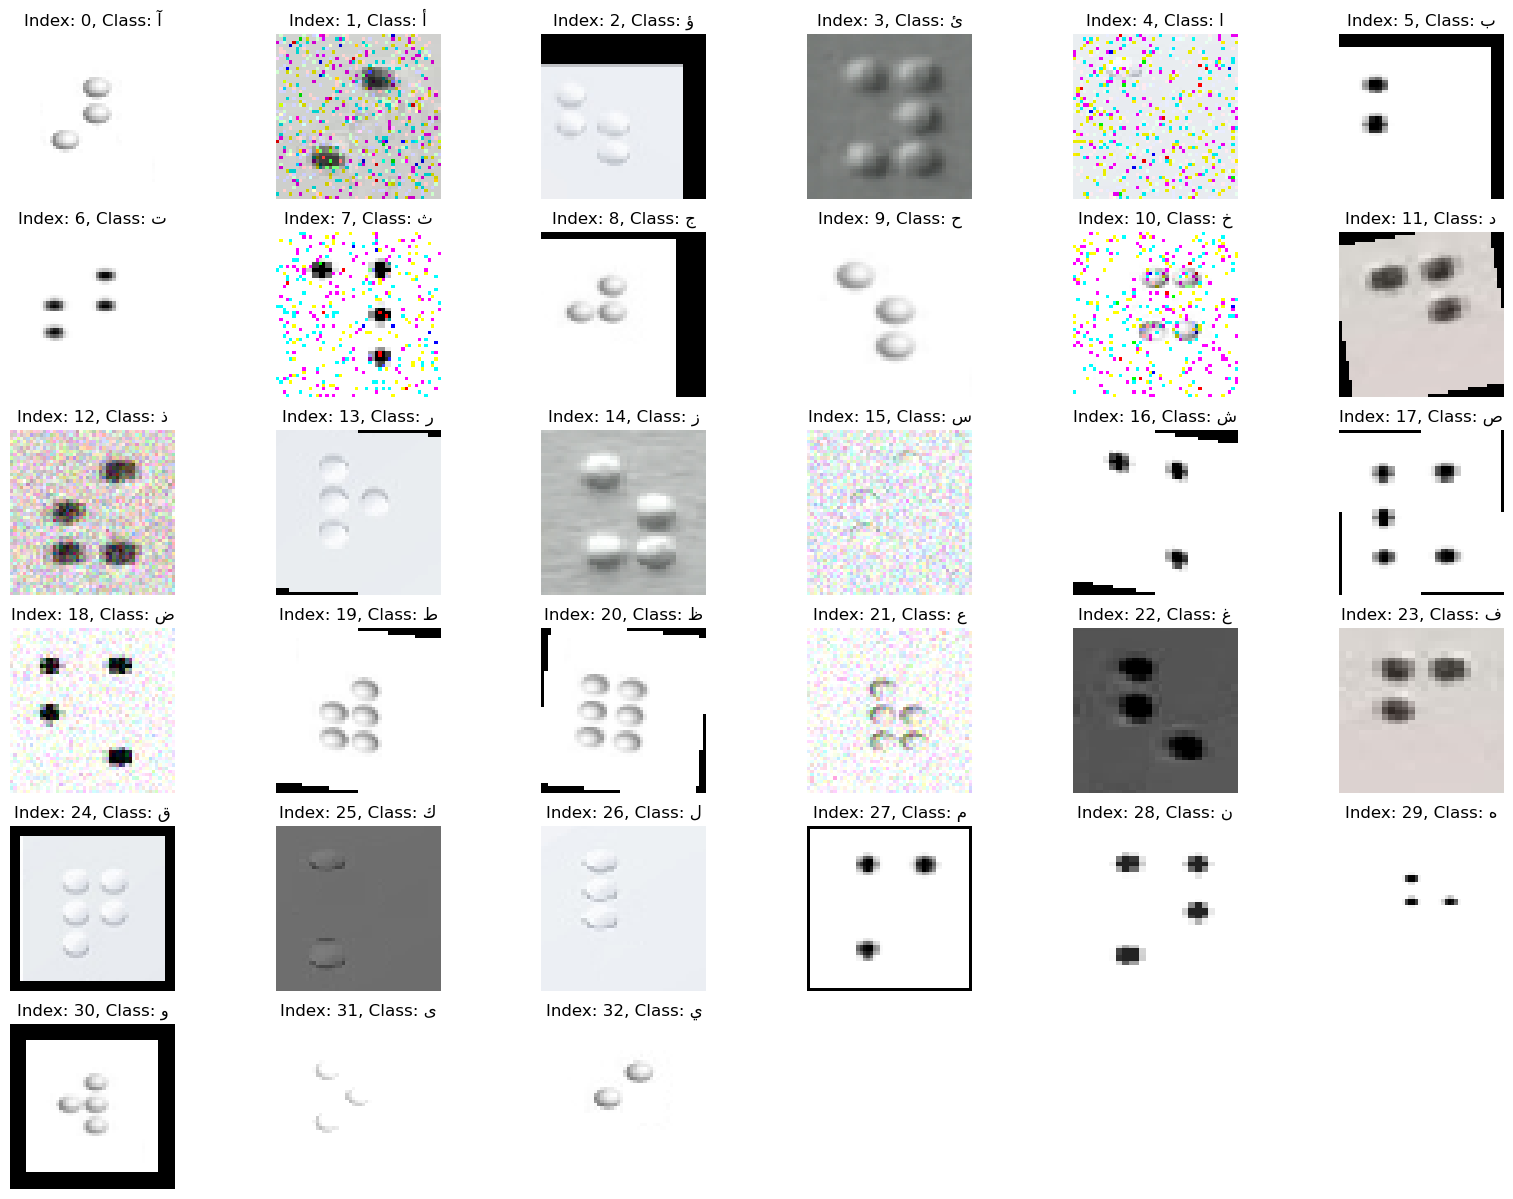

In [7]:
# Create a figure with subplots
plt.figure(figsize=(20, 15))

# Iterate over each class
for class_index in range(len(class_names)):
    # Filter the dataset for images from the current class and take the first image
    filtered_dataset = dataset.filter(lambda x, y: tf.math.equal(y[0], class_index)).take(1)

    # Get the first image and label from the filtered dataset
    for image, label in filtered_dataset:
        # Display the image
        plt.subplot(len(class_names) // 6 + 1, 6, class_index + 1) 
        plt.imshow(image[0].numpy().astype("uint8"))
        plt.title(f"Index: {class_index}, Class: {class_names[class_index]}")
        plt.axis("off")

# Show the plot
plt.show()


In [8]:
# Function to normalize the images
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Apply normalization to the datasets
train_dataset = train_dataset.map(normalize)
validation_dataset = validation_dataset.map(normalize)

In [11]:
# Define the CNN model with larger kernel sizes
model = models.Sequential([
    # First Convolutional Layer with larger kernel
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(50, 50, 3)),  # Changed to 5x5
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Second Convolutional Layer with larger kernel
    layers.Conv2D(64, (5, 5), activation='relu'),  # Changed to 5x5
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Third Convolutional Layer with larger kernel
    layers.Conv2D(128, (5, 5), activation='relu'),  # Changed to 5x5
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Flatten the output to feed into a dense layer
    layers.Flatten(),

    # Fully Connected Dense Layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output layer for classification
    layers.Dense(33, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy'
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 19, 19, 64)        51264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 9, 9, 64)         

In [12]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20
)

Epoch 1/20


82/82 [==============================] - 3s 25ms/step - loss: 3.5025 - accuracy: 0.0279 - val_loss: 3.4969 - val_accuracy: 0.0230
Epoch 2/20
82/82 [==============================] - 2s 21ms/step - loss: 3.4802 - accuracy: 0.0348 - val_loss: 3.4424 - val_accuracy: 0.0689
Epoch 3/20
82/82 [==============================] - 2s 21ms/step - loss: 3.2061 - accuracy: 0.1163 - val_loss: 2.5835 - val_accuracy: 0.3752
Epoch 4/20
82/82 [==============================] - 2s 21ms/step - loss: 2.4914 - accuracy: 0.2896 - val_loss: 1.8670 - val_accuracy: 0.5865
Epoch 5/20
82/82 [==============================] - 2s 21ms/step - loss: 1.9556 - accuracy: 0.4606 - val_loss: 1.3336 - val_accuracy: 0.6738
Epoch 6/20
82/82 [==============================] - 2s 23ms/step - loss: 1.6042 - accuracy: 0.5524 - val_loss: 1.0413 - val_accuracy: 0.7718
Epoch 7/20
82/82 [==============================] - 2s 21ms/step - loss: 1.3878 - accuracy: 0.6102 - val_loss: 0.8916 - val_accuracy: 0.7871
Epoch 8/20
82/82 [======

In [13]:
print(f"Accuracy: {history.history['val_accuracy'][-1]:.2f}")

Accuracy: 0.90


1/1 [==============================] - 0s 87ms/step


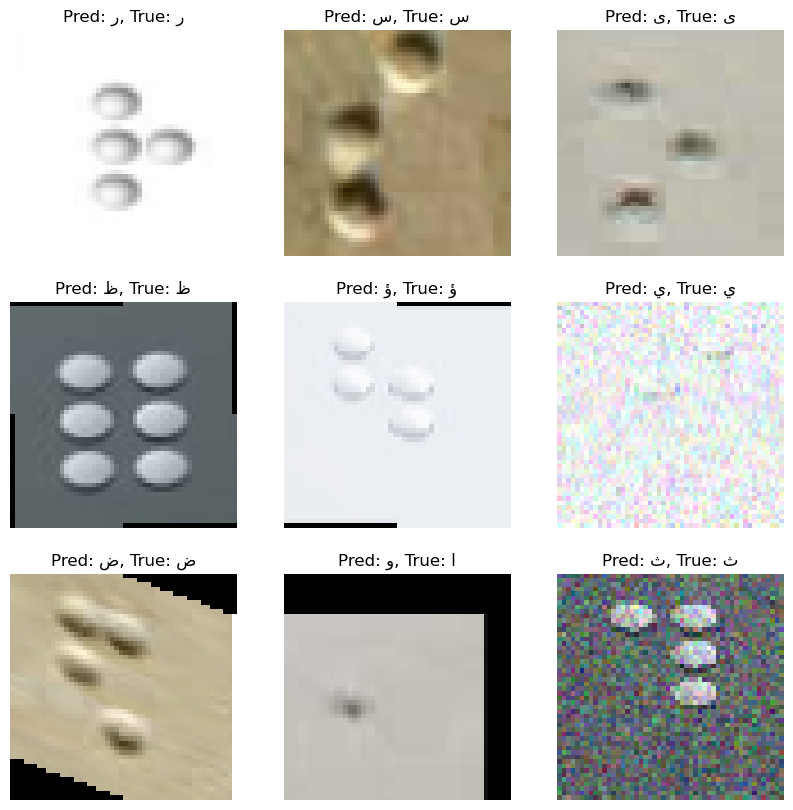

In [14]:
# Load a batch of images for prediction
for images, labels in validation_dataset.take(1):  # Take a single batch from the validation dataset
    predictions = model.predict(images)  # Predict on the batch
    predicted_labels = np.argmax(predictions, axis=1)  # Get the predicted class for each image

    # Plot a few sample images with their predicted labels
    plt.figure(figsize=(10, 10))
    
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i+1)
        
        plt.imshow(images[i].numpy())
        
        plt.title(f"Pred: {class_names[predicted_labels[i]]}, True: {class_names[labels[i].numpy()]}")  # Show predicted and true label
        plt.axis("off")
    
    plt.show()

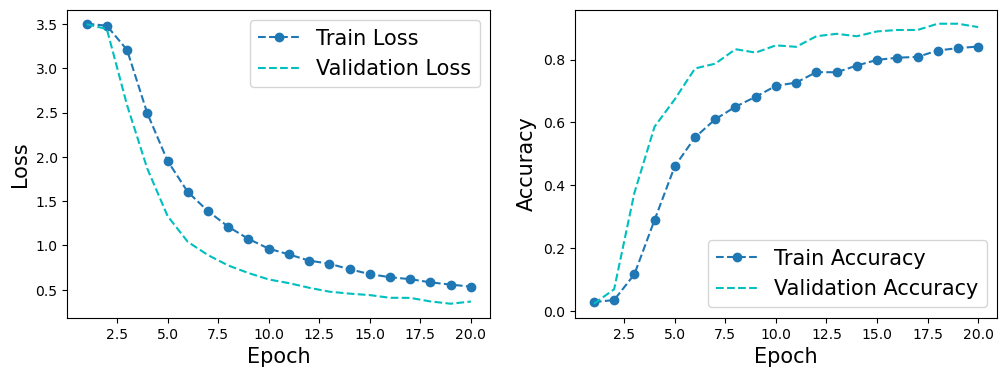

In [15]:
hist = history.history
x_arr = np.arange(len(hist['loss']))+1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr,hist['loss'],'--o',label='Train Loss')
ax.plot(x_arr,hist['val_loss'],'--c',label='Validation Loss')
ax.set_xlabel('Epoch',size=15)
ax.set_ylabel('Loss',size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr,hist['accuracy'],'--o',label='Train Accuracy')
ax.plot(x_arr,hist['val_accuracy'],'--c',label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch',size=15)
ax.set_ylabel('Accuracy',size=15)
plt.show()

1/1 [==============================] - 0s 89ms/step


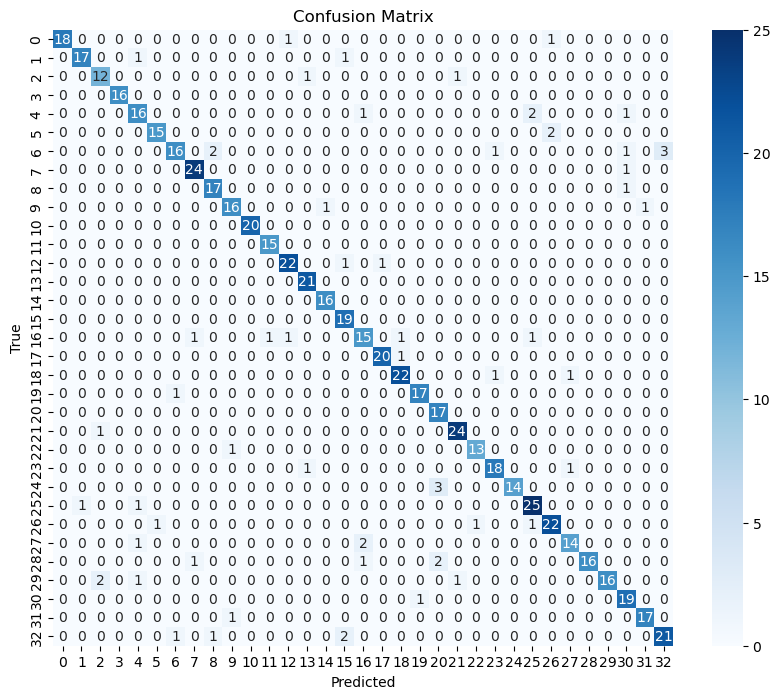

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.94      0.89      0.92        19
           2       0.80      0.86      0.83        14
           3       1.00      1.00      1.00        16
           4       0.80      0.80      0.80        20
           5       0.94      0.88      0.91        17
           6       0.89      0.70      0.78        23
           7       0.92      0.96      0.94        25
           8       0.85      0.94      0.89        18
           9       0.89      0.89      0.89        18
          10       1.00      1.00      1.00        20
          11       0.94      1.00      0.97        15
          12       0.92      0.92      0.92        24
          13       0.91      1.00      0.95        21
          14       0.94      1.00      0.97        16
          15       0.83      1.00      0.90        19
          16       0.79      0.75      0.77        20
          17       0.95    

In [16]:
# Load true labels and predicted labels from the validation dataset
true_labels = []
predicted_labels = []

# Loop through the validation dataset to get true labels and predictions
for images, labels in validation_dataset:
    predictions = model.predict(images)  # Predict on the batch
    predicted_labels_batch = np.argmax(predictions, axis=1)  # Get predicted class
    predicted_labels.extend(predicted_labels_batch)  # Collect predicted labels
    true_labels.extend(labels.numpy())  # Collect true labels

# Convert lists to numpy arrays for confusion matrix
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(true_labels, predicted_labels))

In [17]:
# After training your model, save it to a file
model.save('models/Braille-v2.h5')